# Predicting direction of stock price from interest rate and inflation rate


_We utilized logistic regression to analyze the stock price data and provided a predictive model._

by Allan Lee, Jianhao Zhang, Yi Yan and Chengyu Tao (DSCI 522 Group 3 Milestone 1)

2023/11/17

In [1]:
import yfinance as yf
import pandas as pd
import altair as alt
alt.data_transformers.enable("vegafusion")

DataTransformerRegistry.enable('vegafusion')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import data_read

In [3]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

## Summary

## Introduction

During the COVID-19 pandemic, central banks around the world lowered interest rates to ease economical challenges posed by the pandemic. As the pandemic ease, the lowered interest rate leads to excess consumer spending which increased the inflation rate to unacceptable levels. In order to control the inflation and have it return to pre-pandemic levels, the central bank raised the interest rate sharply to the highest level in 15 years. Nowadays, inflation and interest rate often takes the headline of financial news and with more than 50% of American households owning stocks, our team is curious to find out how inflation and interest rate affect stock returns. We ask the question: given inflation rate and interest rate data, can we predict whether we will profit if we invest in a stock market index and hold for 1 year.

## Methods & Results
### Data
#### Raw
1. We decided to use the Standard & Poors 500 Index (S&P500) as stock market proxy. The index tracks stocks of 500 largest companies in USA. The price of S&P500 is obtained from Yahoo Finance.
2. Inflation data is obtained from calculating the change of consumer price index (CPI). We obtained United States CPI from the Federal Reserve Economic Data website and computed yearly inflation rate.
3. We can use the Federal funds rate as proxy for interest rate. It is the target interest rate set by the Federal reserve for commercial banks to lend and borrow overnight. We obtained the Federal funds rate from the Federal Reserve Economic Data website.
#### Derived
We derived the change in inflation rate and change in interest rate from the data we have as additional feature. We often hear on the news that inflaiton and interest rate are increasing or decreasing thus we thought these 2 features might provide additional predicting power for our model

#### Analysis

The Python programming language (Van Rossum, G.,& Fred L. D., 2009) and the following Python packages were used to perform the analysis: Numpy (Harris et al. 2020), Pandas (McKinney, 2010), Altair (VanderPlas, 2018), Scikit-learn (Pedregosa et al. 2011). The code used to perform the EDA and create the report which can be found here: https://github.com/UBC-MDS/dsci_522_group_3/tree/main.

#### Remarks
##### Resampling
S&P500 index, CPI, and Interest rate data we obtained have different sampling frequencies. CPI data has the lowest frequency and it is sampled every first day of the month. We decided to resample all data to last day of every month thus it is easy to calculate and interpret year-year and month-month change. Interest rate data was sampled daily and it is noisy. We decided to filter the data by taking monthly median during resampling. The following table summarizes how data preprocessing was done.


| Data | Original sampling period | Preprocess procedure |
| -------- | -------- | -------- |
| S&P 500 Index | daily | Take the value from last day of month. If we do not have data for last day of month, use the data from the closest previous date |
| CPI | first day of every month | Offset the date by 1 to last day of last month. We thought the value difference for 1 day is neglegible |
| Interest Rate | daily | Resample to the last day of month by taking the median price of for every day of the month to filter for noise |


 


### Read Data From Web

### Read Data From Web

Here we read all data.

#### columns
| column name            | description                                                                                |
|------------------------|--------------------------------------------------------------------------------------------|
| gspc                   | price of S&P 500 stock index (will be ignored for model)                                   |
| inflation_rate_pct     | 1 year inflation rate (12 months ago to now) (will be a feature for model)                 |
| interest_rate_pct      | interest rate (will be a feature for model)                                                |                                           
| inflation_rate_pct_chg | change of inflation between now and 12 months ago (will be a feature for model)            |       
| interest_rate_pct_chg  | change of interest rate between now and 12 months ago (will be a feature for model)        |   
| gspc_prev_year_chg_pct | change of gspc between now and 12 months ago (will be a feature for model)                 |            
| gspc_next_year_pct_chg | change of gspc between now and 12 months later (will be used to get target)                | 
| target                 | whether gspc increased 12 months later compared to now (will be target for classification) |                      
 

In [4]:
data_df: pd.DataFrame = data_read.get_all_data()

In [5]:
data_df.head()

,gspc,gspc_next_year_pct_chg,gspc_prev_year_pct_chg,inflation_rate_pct,inflation_rate_pct_chg,interest_rate_pct,interest_rate_pct_chg,target
date,,,,,,,,
1955-07-31,43.520000,13.488049,40.932648,-0.371747,-0.371747,1.69,0.94,True
1955-08-31,43.180000,10.027786,44.753605,0.373134,0.744882,2.00,0.62,True
1955-09-30,43.669998,3.847035,35.159382,0.373134,1.113875,2.19,1.00,True
1955-10-31,42.340000,7.652342,33.648989,0.373134,0.744882,2.25,1.25,True
1955-11-30,45.509998,-0.944840,32.914708,0.374532,1.118026,2.25,1.37,False


In [6]:
data_df.tail()

,gspc,gspc_next_year_pct_chg,gspc_prev_year_pct_chg,inflation_rate_pct,inflation_rate_pct_chg,interest_rate_pct,interest_rate_pct_chg,target
date,,,,,,,,
2022-06-30,3785.379883,17.567590,-11.916698,8.524815,3.159340,1.205,1.145,True
2022-07-31,4130.290039,11.105029,-6.028534,8.262693,3.011421,1.580,1.480,True
2022-08-31,3955.000000,13.973708,-12.551853,8.201670,2.811321,2.330,2.230,True
2022-09-30,3585.620117,19.590187,-16.759448,7.745427,1.523558,2.330,2.250,True
2022-10-31,3871.979980,8.311505,-15.924851,7.110323,0.301320,3.080,3.000,True


### EDA
#### Time series plot of all variables

In [7]:
(alt
 .Chart(data_df)
 .mark_line()
 .encode(x=alt.X('date', type='temporal'),
         y=alt.Y(alt.repeat('row'), type='quantitative'))
 .properties(width=500, height=200)
 .repeat(row=['gspc', 'inflation_rate_pct', 'interest_rate_pct', 'inflation_rate_pct_chg',
              'interest_rate_pct_chg', 'gspc_prev_year_pct_chg', 'gspc_next_year_pct_chg',
              'target']))

alt.RepeatChart(...)

In [8]:
df = data_df

In [9]:
# Column data types 
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 808 entries, 1955-07-31 to 2022-10-31
Freq: M
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   gspc                    808 non-null    float64
 1   gspc_next_year_pct_chg  808 non-null    float64
 2   gspc_prev_year_pct_chg  808 non-null    float64
 3   inflation_rate_pct      808 non-null    float64
 4   inflation_rate_pct_chg  808 non-null    float64
 5   interest_rate_pct       808 non-null    float64
 6   interest_rate_pct_chg   808 non-null    float64
 7   target                  808 non-null    bool   
dtypes: bool(1), float64(7)
memory usage: 51.3 KB


- No NA or missing data in df
- One row record the observation for one month.
- The time series data is from 1955-07 to 2022-10, which contains 808 observations.
- The target is True when the stock price went up, and is False when the stock price went down.
- We will use four columns 'inflation_rate_pct', 'interest_rate_pct',
       'inflation_rate_pct_chg', 'interest_rate_pct_chg',
       'gspc_prev_year_pct_chg' as features, and the target as response in this binary classification problem. 

# Split data and EDA

In [10]:
# split data into training and test
train_df, test_df = train_test_split(df, test_size=0.2, random_state=123)
train_df

,gspc,gspc_next_year_pct_chg,gspc_prev_year_pct_chg,inflation_rate_pct,inflation_rate_pct_chg,interest_rate_pct,interest_rate_pct_chg,target
date,,,,,,,,
2013-04-30,1597.569946,17.925976,14.282744,1.361965,-0.342289,0.150,0.000,True
1982-12-31,140.639999,17.271042,14.761319,3.711559,-4.679246,8.830,-3.470,True
1968-01-31,92.239998,11.676067,6.500401,3.951368,1.138868,4.630,-0.370,True
2005-04-30,1156.849976,13.291266,4.474842,2.802750,-0.249021,2.765,1.765,True
1986-02-28,226.919998,25.242383,25.245616,2.255639,-1.448065,7.830,-0.695,True
...,...,...,...,...,...,...,...,...
1963-09-30,71.699997,17.405863,27.421355,1.315789,-0.017544,3.500,0.500,True
1982-05-31,111.879997,45.146589,-15.619579,7.064018,-2.488582,14.590,-3.900,True
1987-05-31,290.100006,-9.631162,17.283202,3.652968,1.887169,6.750,-0.090,False


In [11]:
# statistical summary for dataframe
train_df.describe()

,gspc,gspc_next_year_pct_chg,gspc_prev_year_pct_chg,inflation_rate_pct,inflation_rate_pct_chg,interest_rate_pct,interest_rate_pct_chg
count,646.000000,646.000000,646.000000,646.000000,646.000000,646.000000,646.000000
mean,798.744690,8.330921,8.896338,3.580897,0.121706,4.660387,-0.021447
std,980.640548,16.127271,15.729474,2.724454,2.018540,3.618349,2.019569
min,39.990002,-44.756241,-40.090677,-2.097161,-7.697284,0.050000,-7.200000
25%,96.495001,-1.846929,-0.707483,1.719694,-0.930306,1.990000,-0.870000
50%,329.439987,9.916350,10.199292,2.950167,0.087853,4.255000,0.030000
75%,1239.537445,18.816788,18.699661,4.415594,1.139363,6.253750,0.977500
max,4766.180176,53.714506,53.714506,14.756447,6.194849,19.490000,9.710000


In [12]:
train_df.columns

Index(['gspc', 'gspc_next_year_pct_chg', 'gspc_prev_year_pct_chg',
       'inflation_rate_pct', 'inflation_rate_pct_chg', 'interest_rate_pct',
       'interest_rate_pct_chg', 'target'],
      dtype='object')

In [28]:
features = ['inflation_rate_pct', 'interest_rate_pct',
       'inflation_rate_pct_chg', 'interest_rate_pct_chg',
       'gspc_prev_year_pct_chg']

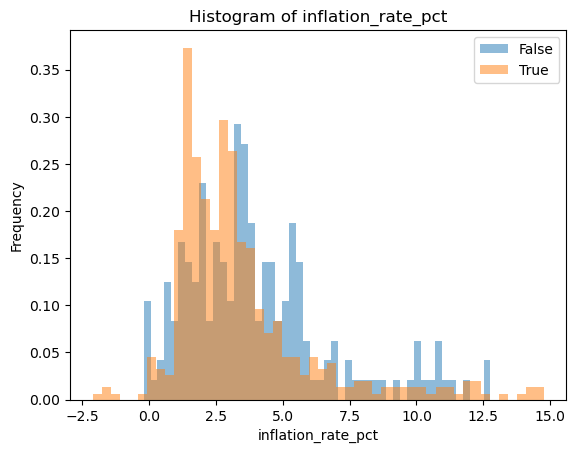

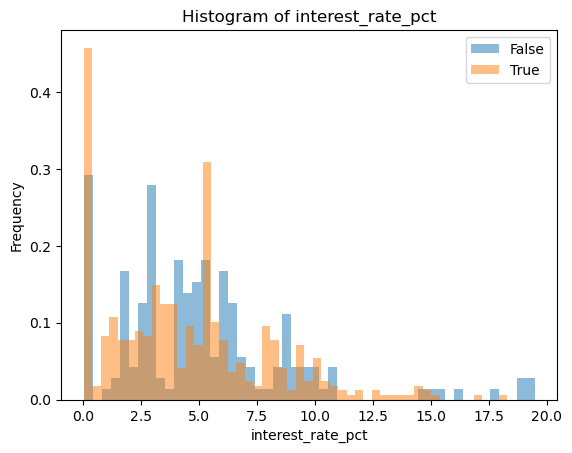

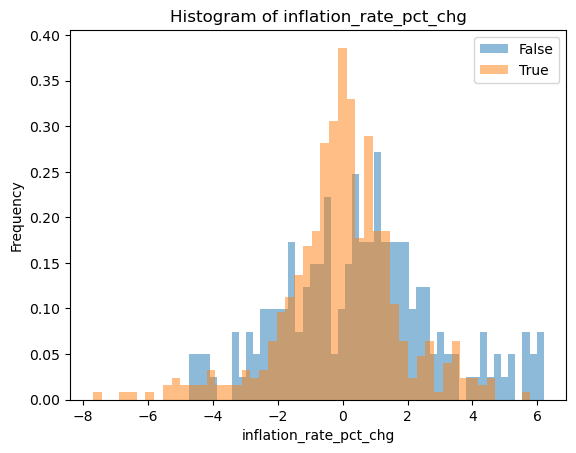

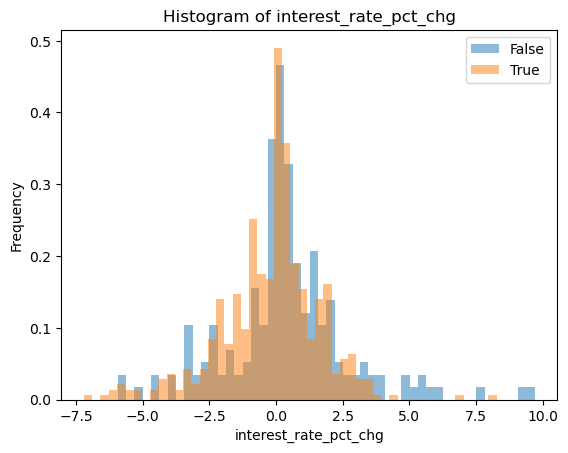

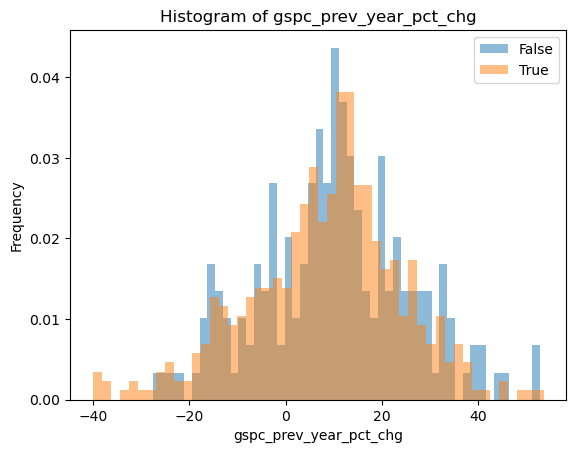

In [37]:
import eda
eda.plot_histograms(train_df, "target", features)

In [40]:
# finding potential correlation between numeric columns
num_col = train_df.select_dtypes(include=['float64']).columns.tolist()

train_df[num_col].corr('spearman').style.background_gradient()

,gspc,gspc_next_year_pct_chg,gspc_prev_year_pct_chg,inflation_rate_pct,inflation_rate_pct_chg,interest_rate_pct,interest_rate_pct_chg
gspc,1.000000,0.004119,0.143328,-0.162305,-0.027353,-0.405997,-0.069132
gspc_next_year_pct_chg,0.004119,1.000000,-0.089052,-0.153216,-0.162459,-0.009630,-0.159286
gspc_prev_year_pct_chg,0.143328,-0.089052,1.000000,-0.169432,-0.196685,-0.032430,-0.110977
inflation_rate_pct,-0.162305,-0.153216,-0.169432,1.000000,0.360932,0.632484,0.145565
inflation_rate_pct_chg,-0.027353,-0.162459,-0.196685,0.360932,1.000000,0.043780,0.485318
interest_rate_pct,-0.405997,-0.009630,-0.032430,0.632484,0.043780,1.000000,0.216758
interest_rate_pct_chg,-0.069132,-0.159286,-0.110977,0.145565,0.485318,0.216758,1.000000


- Spearmean's rank correlation test revealed some potential correlation between columns: 

**interest_rate_pct vs inflation_rate_pct** 

**interest_rate_pct_chg vs inflation_rate_pct_chg**

**inflation_rate_pct_chg vs inflation_rate_pct**

**interest_rate_pct_chg vs interest_rate_pct**

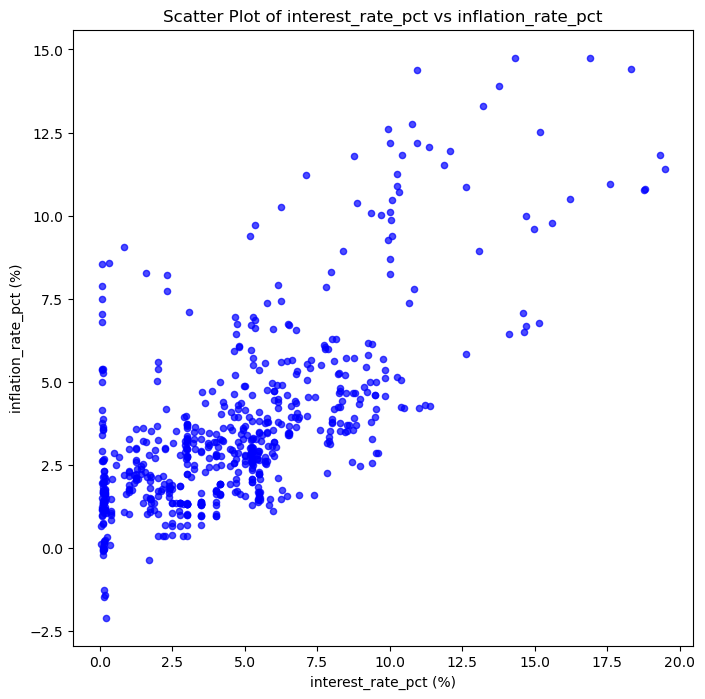

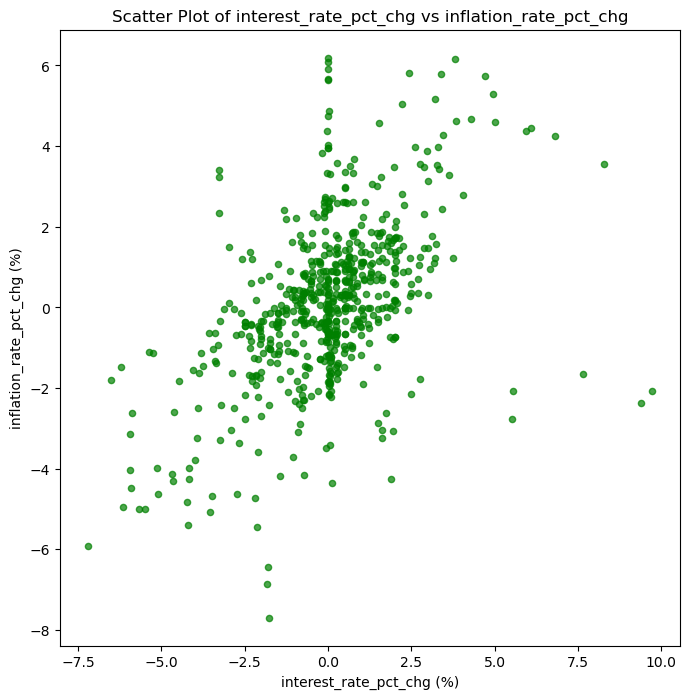

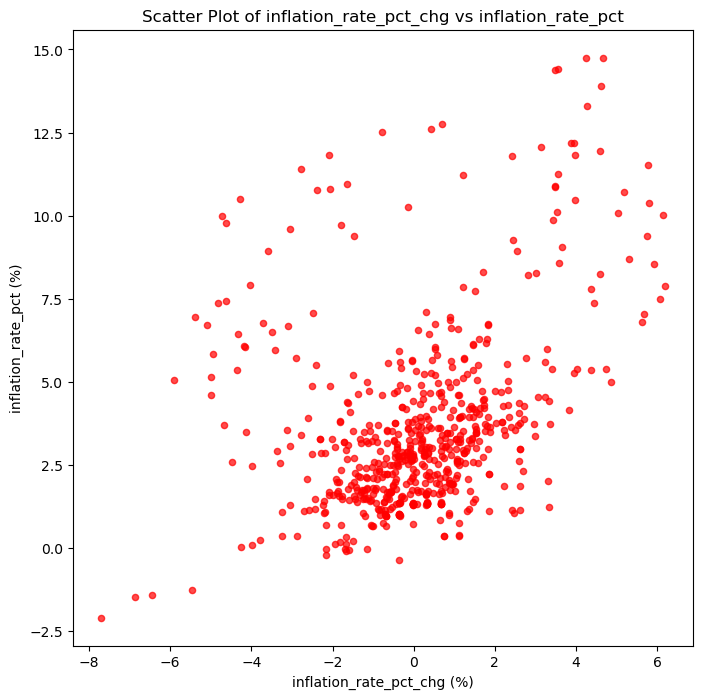

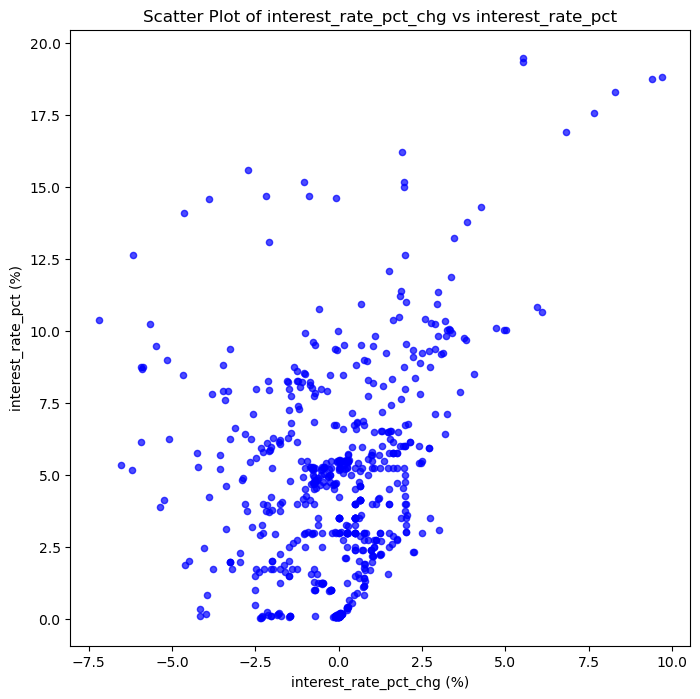

In [38]:
eda.scatter_plot(train_df, 'interest_rate_pct', 'inflation_rate_pct', color='blue')
eda.scatter_plot(train_df, 'interest_rate_pct_chg', 'inflation_rate_pct_chg', color='green')
eda.scatter_plot(train_df, 'inflation_rate_pct_chg', 'inflation_rate_pct', color='red')
eda.scatter_plot(train_df, 'interest_rate_pct_chg', 'interest_rate_pct', color='blue')

- Examine the data type for every column.
- Illustrate the distribution of all numeric columns and investigate possible correlations between them.
- Divide the dataframe into training and testing datasets with an 80:20 ratio.
- Based on the histograms of all columns, the five numerical columns 'inflation_rate_pct', 'interest_rate_pct', 'inflation_rate_pct_chg', 'interest_rate_pct_chg', and 'gspc_prev_year_pct_chg' are helpful in separating the target.

### Model

In [45]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=123)
train_df

,gspc,gspc_next_year_pct_chg,gspc_prev_year_pct_chg,inflation_rate_pct,inflation_rate_pct_chg,interest_rate_pct,interest_rate_pct_chg,target
date,,,,,,,,
2013-04-30,1597.569946,17.925976,14.282744,1.361965,-0.342289,0.150,0.000,True
1982-12-31,140.639999,17.271042,14.761319,3.711559,-4.679246,8.830,-3.470,True
1968-01-31,92.239998,11.676067,6.500401,3.951368,1.138868,4.630,-0.370,True
2005-04-30,1156.849976,13.291266,4.474842,2.802750,-0.249021,2.765,1.765,True
1986-02-28,226.919998,25.242383,25.245616,2.255639,-1.448065,7.830,-0.695,True
...,...,...,...,...,...,...,...,...
1963-09-30,71.699997,17.405863,27.421355,1.315789,-0.017544,3.500,0.500,True
1982-05-31,111.879997,45.146589,-15.619579,7.064018,-2.488582,14.590,-3.900,True
1987-05-31,290.100006,-9.631162,17.283202,3.652968,1.887169,6.750,-0.090,False


In [46]:
#Separate target value form train and test set 
X_train = train_df[['inflation_rate_pct', 'interest_rate_pct',
       'inflation_rate_pct_chg', 'interest_rate_pct_chg',
       'gspc_prev_year_pct_chg']]
y_train = train_df["target"]

X_test = test_df[['inflation_rate_pct', 'interest_rate_pct',
       'inflation_rate_pct_chg', 'interest_rate_pct_chg',
       'gspc_prev_year_pct_chg']]
y_test = test_df["target"]

### Data
The dataset comprises records for 808 months, with each row featuring a crucial predictor for the corresponding month. Additionally, it indicates whether there was an increase or decrease in the S&P 500 index, denoted by the values True or False.


### Preprocessing Data

##### Numeric features:
- 'inflation_rate_pct'
- 'interest_rate_pct'
- 'inflation_rate_pct_chg'
- 'interest_rate_pct_chg'
- 'gspc_prev_year_pct_chg'

Since there is no missing values, imputation is not necessary. And we apply a StandardScaler.

In [47]:
numerical_features = ['inflation_rate_pct', 'interest_rate_pct',
       'inflation_rate_pct_chg', 'interest_rate_pct_chg',
       'gspc_prev_year_pct_chg']

#Create Column Transformer 
preprocessor = make_column_transformer(    
    (StandardScaler(), numerical_features),  
)

### Model Selection
##### Logistic Regression
Our focus is on identifying whether there is an increase in the S&P 500 index, making it a classification problem. To tackle this, we utilize Logistic Regression.

In [48]:
pipe = make_pipeline(preprocessor, LogisticRegression())

In [49]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['inflation_rate_pct',
                                                   'interest_rate_pct',
                                                   'inflation_rate_pct_chg',
                                                   'interest_rate_pct_chg',
                                                   'gspc_prev_year_pct_chg'])])),
                ('logisticregression', LogisticRegression())])

In [50]:
pipe.score(X_test, y_test)

0.7530864197530864

The test data of logistic regression yields an accuracy of 75.3%. Accuracy is a metric calculated as the ratio of correct predictions to all predictions. Nevertheless, caution is necessary when interpreting this metric, particularly in the context of class imbalance.

##### Dummy Regression

In [51]:
from sklearn.dummy import DummyClassifier

dc = DummyClassifier()
dc.fit(X_train, y_train)

DummyClassifier()

In [52]:
dc.score(X_test, y_test)

0.7592592592592593

### Discussion
The model training is designed such that it follows the Golden Rule. The test data of dummy regression yields an accuracy of 75.9%. The accuracy of dummy regression is better then the accuracy of logistic regression. In the preceding examination, we utilize `Logistic Regression` and `Dummy Regression`. Consequently, the result does not show advantage of `Logistic Regression` over `Dummy Regression`. Further data preprocessing is needed to enhance the overall effectiveness of the model. This is aligned with expectation, because we do not have enough meaningful features to extract information that is helpful for a more accurate categorization. Also, we have imbalanced classes, which can also prevent the model from determining whether the index will grow. 

The model's performance may be sensitive to hyperparameter settings, therefore it can be helpful to improve the model performance to experiment with different configurations through hyperparameter tuning. In the future, to improve the performance of the model, we may want to consult with specialists of finance field to get more key information about the topic. This will allow more features to be added to the data and positively impact the model training. 



### Reference

Harris, C.R. et al., (2020). Array programming with NumPy. Nature, 585, pp.357--362.

Jed Wing et al., (2019). Caret: Classification and Regression Training. https://CRAN.R-project.org/package=caret.

McKinney, W. (2010). "Data Structures for Statistical Computing in Python." In Proceedings of the 9th Python in Science Conference, edited by Stéfan van der Walt and Jarrod Millman, 51--56.

Pedregosa, F. et al., (2011). Scikit-learn: Machine learning in Python. Journal of machine learning research, 12(Oct), pp.2825--2830.

VanderPlas, J. et al., (2018). Altair: Interactive statistical visualizations for python. Journal of open source software, 3(32), p.1057.

Van Rossum, G.,& Fred L. D. (2009). Python 3 Reference Manual. Scotts Valley, CA: CreateSpace.

Yahoo!. S&P 500 (^GSPC) charts, Data & News. Yahoo! Finance. https://ca.finance.yahoo.com/quote/%5EGSPC?p=%5EGSPC&.tsrc=fin-srch